## Image Classification with CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importing required libraries 

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Setting the path and batch size

In [4]:
PATH = "courses/dl1/data/dogscats/"
sz=224

Checking if cuda is working fine 

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

Looking at the file structure 

In [7]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [9]:
files = os.listdir(f'{PATH}valid/cats')[:5]

In [10]:
files

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

In [11]:
img = plt.imread(f'{PATH}/valid/cats/{files[0]}')

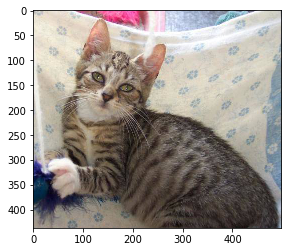

In [12]:
plt.imshow(img)

In [13]:
img.shape

(437, 499, 3)

In [14]:
img[:4,:4]

array([[[211, 211, 219],
        [210, 211, 216],
        [208, 207, 213],
        [202, 201, 206]],

       [[200, 201, 206],
        [199, 198, 204],
        [196, 195, 200],
        [193, 192, 197]],

       [[193, 192, 197],
        [189, 188, 193],
        [184, 183, 188],
        [185, 185, 187]],

       [[197, 195, 198],
        [189, 187, 190],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

Let's now use a pretrained resnet34 model 

In [15]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.043052   0.025239   0.991699  
    1      0.042749   0.021347   0.992188                     



[0.021346588, 0.9921875]

In [16]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [17]:
log_preds[:10]

array([[ -0.00004, -10.07926],
       [ -0.00115,  -6.76952],
       [ -0.00188,  -6.27532],
       [ -0.00036,  -7.94235],
       [ -0.00005,  -9.98612],
       [ -0.00014,  -8.89616],
       [ -0.00016,  -8.72003],
       [ -0.00004, -10.16563],
       [ -0.00073,  -7.22523],
       [ -0.00002, -10.69436]], dtype=float32)

In [18]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct):return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [21]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [22]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


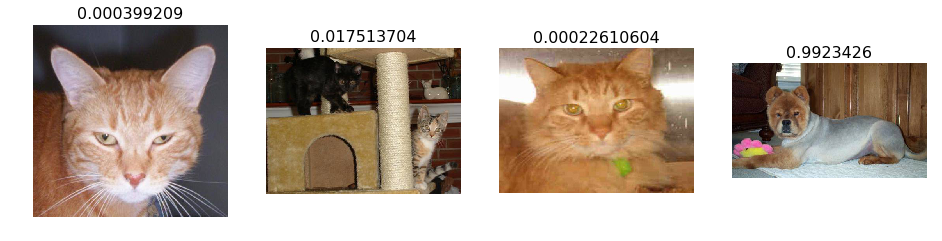

In [23]:

# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


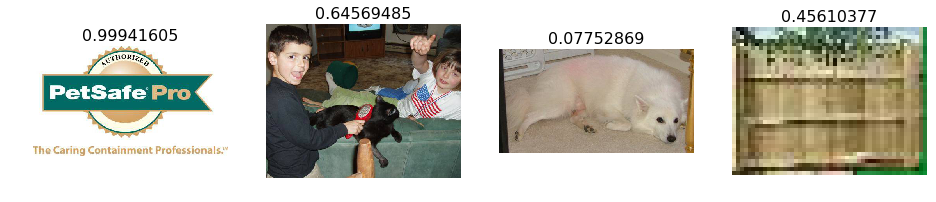

In [24]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [25]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


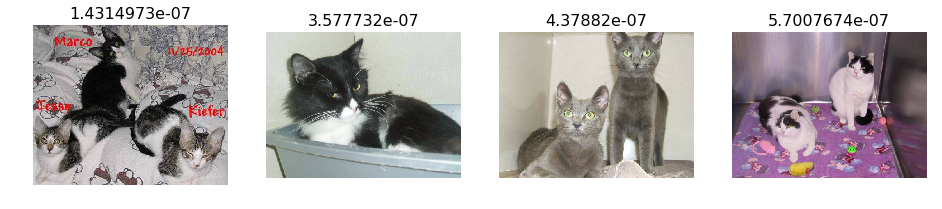

In [26]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


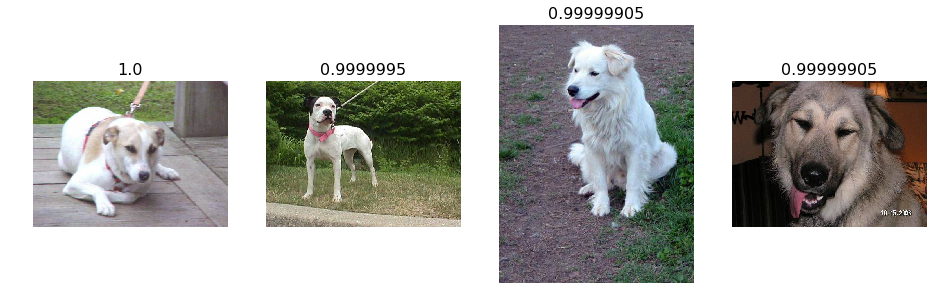

In [27]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


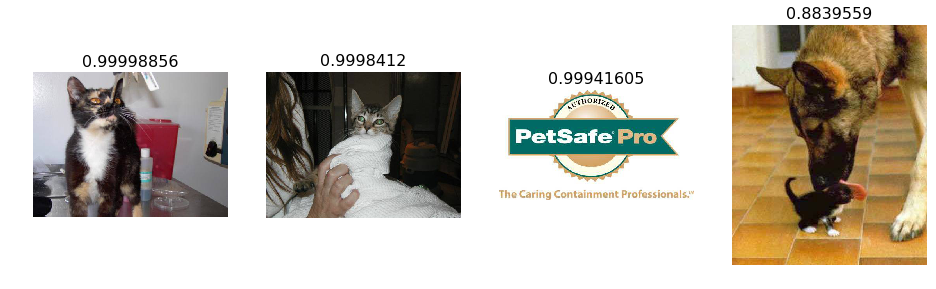

In [28]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


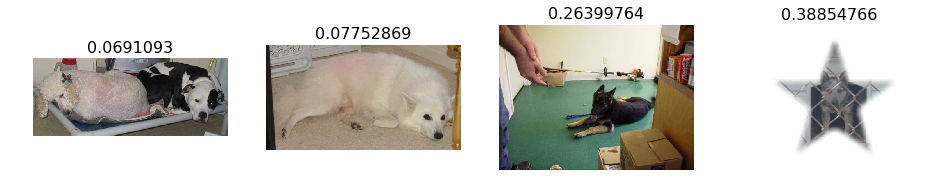

In [29]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


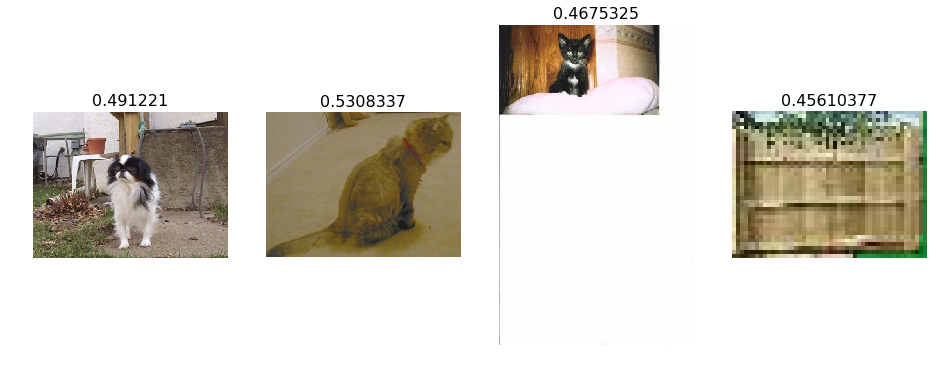

In [30]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [31]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [32]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▊  | 283/360 [00:04<00:01, 66.88it/s, loss=0.369] 


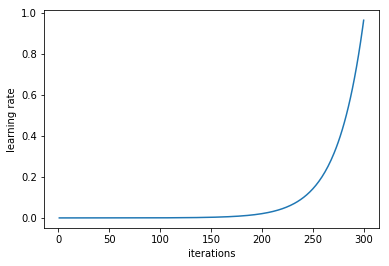

In [33]:
learn.sched.plot_lr()

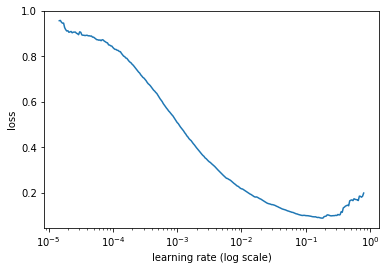

In [34]:
learn.sched.plot()

In [35]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [36]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]


In [37]:
ims = np.stack([get_augs() for i in range(6)])

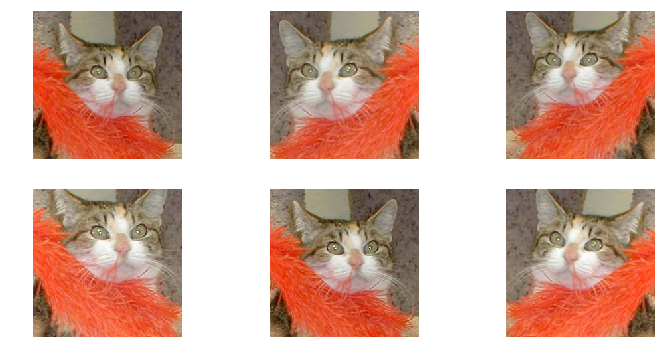

In [38]:
plots(ims, rows=2)

In [39]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [40]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.045557   0.025625   0.991699  



[0.025624935, 0.99169921875]

In [41]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.039318   0.022967   0.993652  
    1      0.035318   0.023162   0.993652                     
    2      0.031879   0.027448   0.990234                     



[0.02744838, 0.990234375]

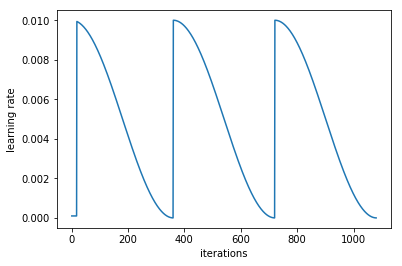

In [42]:
learn.sched.plot_lr()

In [43]:
learn.save('224_lastlayer')

In [44]:
learn.load('224_lastlayer')

In [45]:
learn.unfreeze()

In [46]:
lr=np.array([1e-4,1e-3,1e-2])

In [47]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.044485   0.025253   0.990234  
    1      0.042164   0.026067   0.991211                     
    2      0.034487   0.025568   0.990723                     
    3      0.042658   0.027313   0.989746                     
    4      0.043422   0.026779   0.988281                     
    5      0.036069   0.024679   0.990234                     
    6      0.031641   0.024787   0.990723                     



[0.024787044, 0.99072265625]

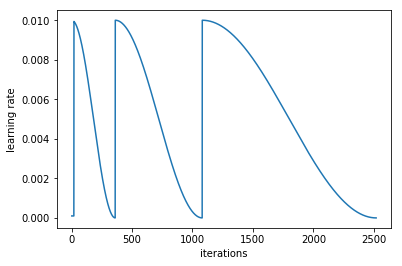

In [48]:
learn.sched.plot_lr()

In [49]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)


In [52]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[988  12]
 [  6 994]]


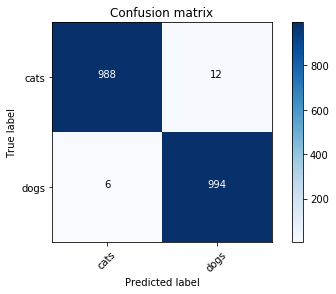

In [54]:
plot_confusion_matrix(cm, data.classes)

In [55]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [56]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

In [ ]:
binary_loss()